# Simple Chatbot using LangGraph
Refer to github for more info: https://github.com/menloparklab/LangGraphJourney/blob/main/LangGraphLearning.ipynb

In [58]:
# Activate virtual environment
!source .venv/bin/activate

In [59]:
# Install LangGraph package
%pip install langgraph==0.1.7
%pip install httpx # package needed for langgraph
%pip install langchain langchain_openai
%pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
from langgraph.graph import Graph

In [63]:
def function_1(input_1):
    return input_1 + " Hi "

def function_2(input_2):
    return input_2 + "there"

## Setting up our graph

In [64]:
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('node_1', 'node_2')

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [65]:
app.invoke("Hello")

'Hello Hi there'

Our chatbot calls the functions to concatenate "Hi" and "there" to the prompt (which is "Hello") but doesn't actually respond with a custom output. It only gives the result of the function call. 

Let's fix this by first visualizing our graph

### To Display our graphs
More info on displaying here: 
https://github.com/langchain-ai/langgraph/blob/main/examples/visualization.ipynb

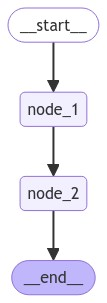

In [66]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod#, NodeColors

display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [67]:
# Stream the responses so we can see the flow of each node in text
input = 'Hello'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Hello Hi 

---

Output from node 'node_2':
---
Hello Hi there

---



We can now see what's happening at every level. Let's connect our chatbot to this flow.

## Getting API key from our .env file

In [68]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")

## Creating & prompting the chatbot model

In [69]:
from langchain_openai import ChatOpenAI

# Set the model as ChatOpenAI
model = ChatOpenAI(temperature=0) 

# Call the model with a user message
model.invoke('Hey there')

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-2871fce2-62cc-4a86-83d4-8db52eff0a14-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})

In [70]:
# Call .content if you want just the AI response
response = model.invoke('Hey there')
response.content

'Hello! How can I assist you today?'

## Creating a City Temperature bot

### Create agent for parsing city name

Pay special attention to this function. The complete_query concatenates instructions before the user prompt, guiding our agent's response.

**An agent in LangGraph is defined as a function with instructions + model response placed within a node.**

In [71]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

In [72]:
# Define a Langchain graph
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('agent', 'node_2')  # Edges connect nodes

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()

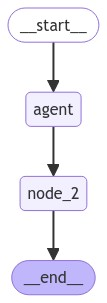

In [74]:
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [76]:
app.invoke("What's the temperature in Las Vegas")  # Should correctly give the city name

'Agent Says: Las Vegas'

### Create agent for running weather API
This agent will get the temperature for the given city from an API.

First we will load in our API functions (this one is preloaded into LangChain so it's easy to access)

In [77]:
%pip install setuptools
%pip install pyowm
%pip install langchain_community


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [78]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
load_dotenv()
os.environ["OPENWEATHERMAP_API_KEY"] = os.environ.get("OPENWEATHERMAP_API_KEY")

weather = OpenWeatherMapAPIWrapper()

Test that the API works

In [79]:
weather_data = weather.run("Las Vegas")
print(weather_data)

In Las Vegas, the current weather is as follows:
Detailed status: clear sky
Wind speed: 1.54 m/s, direction: 0°
Humidity: 13%
Temperature: 
  - Current: 41.96°C
  - High: 42.84°C
  - Low: 40.24°C
  - Feels like: 39.78°C
Rain: {}
Heat index: None
Cloud cover: 0%


Create an agent for our API and add to our workflow

In [80]:
def function_2(input_2):
    weather_data = weather.run(input_2)
    return weather_data

In [81]:
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('agent', 'tool')

workflow.set_entry_point("agent")
workflow.set_finish_point("tool")

app = workflow.compile()

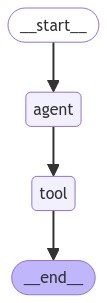

In [82]:
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [83]:
app.invoke("What's the temperature in Las Vegas")

'In Las Vegas, the current weather is as follows:\nDetailed status: clear sky\nWind speed: 1.54 m/s, direction: 0°\nHumidity: 13%\nTemperature: \n  - Current: 41.96°C\n  - High: 42.84°C\n  - Low: 40.24°C\n  - Feels like: 39.78°C\nRain: {}\nHeat index: None\nCloud cover: 0%'

In [85]:
input = "What's the temperature in Las Vegas"
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
Las Vegas

---

Output from node 'tool':
---
In Las Vegas, the current weather is as follows:
Detailed status: clear sky
Wind speed: 1.54 m/s, direction: 0°
Humidity: 13%
Temperature: 
  - Current: 41.96°C
  - High: 42.84°C
  - Low: 40.24°C
  - Feels like: 39.78°C
Rain: {}
Heat index: None
Cloud cover: 0%

---



### Create agent for summarizing response
This agent will read the API response and tell the temperature.

In [86]:
def function_3(input_3):
    complete_query = "Your task is to provide only the temperature based on the weather API response. \
        Provide the temperature in the form of a sentence like you are responding to a user's query. \
        Following is the API response: " + input_3
    response = model.invoke(complete_query)
    return response.content

In [87]:
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("summarizer", function_3)

workflow.add_edge('agent', 'tool')
workflow.add_edge('tool', 'summarizer')

workflow.set_entry_point("agent")
workflow.set_finish_point("summarizer")

app = workflow.compile()

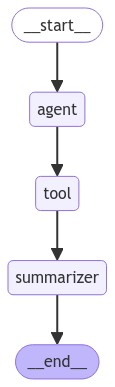

In [88]:
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [89]:
app.invoke("What's the temperature in Las Vegas")

'The current temperature in Las Vegas is 41.96°C.'

In [90]:
input = "What's the temperature in Las Vegas"
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
Las Vegas

---

Output from node 'tool':
---
In Las Vegas, the current weather is as follows:
Detailed status: clear sky
Wind speed: 1.54 m/s, direction: 0°
Humidity: 13%
Temperature: 
  - Current: 41.96°C
  - High: 42.84°C
  - Low: 40.24°C
  - Feels like: 39.78°C
Rain: {}
Heat index: None
Cloud cover: 0%

---

Output from node 'summarizer':
---
The current temperature in Las Vegas is 41.96°C.

---



## Adding summarizer & Graph State

Adding a summarizer agent to interpret API response

**Graph state records/updates the following attributes throughout the run of the graph**
- original user query
- previous gpt response

In [120]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        gpt_response: previous LLM generation
    """

    user_query: str
    gpt_response: str

We now update our functions to take in state as input instead (which records the threaded messages & bot responses)

In [121]:
# Renamed function_1
def city_agent(state):
    user_query = state["user_query"]  # Read query from graph state object
    gpt_response = state["user_query"]  # Read query from graph state object

    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + gpt_response
    response = model.invoke(complete_query)
    return {"user_query": user_query, "gpt_response": response.content} # Return this to update graph state

# Renamed function_2
def weather_agent(state):
    user_query = state["user_query"]
    gpt_response = state["gpt_response"]

    weather_data = weather.run(gpt_response)
    return {"user_query": user_query, "gpt_response": weather_data}

# New function
def summarizer(state):
    user_query = state["user_query"]
    question = state["gpt_response"]

    complete_query = "Your task is to interpret the API response to answer the user's query. \
        Keep it simple. Following is the API response: " + question\
        + "\nFollowing is the user's query: " + user_query
    response = model.invoke(complete_query)
    return {"user_query": user_query, "gpt_response": response.content}


In [122]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("agent", city_agent)
workflow.add_node("tool", weather_agent)
workflow.add_node("summarizer", summarizer)

# Build graph
workflow.add_edge(START, "agent")
workflow.add_edge("agent", "tool")
workflow.add_edge("tool", "summarizer")
workflow.add_edge("summarizer", END)

# Compile
app = workflow.compile()

In [123]:
app.invoke({"user_query": "What can you tell me about Las Vegas?"})

{'user_query': 'What can you tell me about Las Vegas?',
 'gpt_response': 'In Las Vegas, the current weather is clear with a temperature of 42.05°C, low humidity of 13%, and a light wind speed of 2.68 m/s.'}

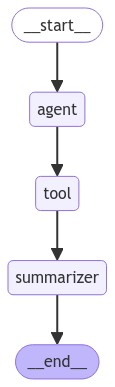

In [124]:
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))